In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
bio_df = pd.read_excel('data/expression_data.xlsx', engine='openpyxl')

In [5]:
bio_df = bio_df.drop(bio_df.columns[0], axis=1)
proteins = bio_df.columns.tolist()


In [6]:
uniprot_to_reactome = pd.read_csv('data/MMU_Uniprot2Reactome.txt', sep='\t')

existing_proteins = uniprot_to_reactome[uniprot_to_reactome['V1'].isin(proteins)]['V1'].unique()

existing_proteins_list = existing_proteins.tolist()
len(existing_proteins_list)

1631

In [ ]:
existing_proteins_list


In [51]:
from py2neo import Graph
import networkx as nx


graph = Graph("bolt://localhost:7688", auth=("neo4j", "123456789"))


query = """
WITH "MATCH (r:Reaction)-[rel]-(connectedNodes)
WHERE r.schemaClass = 'Reaction' AND r.speciesName = 'Mus musculus'
RETURN connectedNodes,rel" AS query
CALL apoc.export.graphml.query(query, "mouse_python.graphml", {format:"gephi", useTypes:true, readLabels:True})
YIELD file, source, format, nodes, relationships, properties, time, rows, batchSize, batches, done, data
RETURN file, source, format, nodes, relationships, properties, time, rows, batchSize, batches, done, data;

"""
graph.run(query).data()




[{'file': 'mouse_python.graphml',
  'source': 'statement: nodes(37867), rels(111678)',
  'format': 'graphml',
  'nodes': 37867,
  'relationships': 111678,
  'properties': 578736,
  'time': 1847,
  'rows': 149545,
  'batchSize': -1,
  'batches': 0,
  'done': True,
  'data': None}]

In [19]:
import networkx as nx
from neo4j import GraphDatabase
import json

def fetch_subgraphs(driver, protein_names):
    with driver.session() as session:
        result = session.run("""
        UNWIND $proteinNames AS proteinName
        MATCH (p)-[rel]-(connectedNodes)
        WHERE p.schemaClass = 'EntityWithAccessionedSequence' AND ANY(name IN p.name WHERE name = proteinName)
        RETURN p AS protein, collect(rel) AS relationships, collect(connectedNodes) AS nodes
        """, proteinNames=protein_names)
        return list(result)

def create_subgraph(record):
    subgraph = nx.MultiGraph()
    protein_node = record['protein']
    relationships = record['relationships']
    connected_nodes = record['nodes']
    
    # Add the protein node with its properties
    subgraph.add_node(protein_node.id, **protein_node._properties)
    
    # Add connected nodes and relationships
    for rel, node in zip(relationships, connected_nodes):
        subgraph.add_node(node.id, **node._properties)
        subgraph.add_edge(protein_node.id, node.id, **rel._properties)
    
    return subgraph

def combine_subgraphs(results):
    # Create a list of subgraphs from the results
    subgraphs = [create_subgraph(record) for record in results]
    
    # Use nx.compose_all to combine the subgraphs
    aggregated_graph = nx.compose_all(subgraphs)
    
    return aggregated_graph

def convert_attributes_to_strings(G):
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict)):  
                G.nodes[node][key] = json.dumps(value)
    
    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict)): 
                G.edges[u, v][key] = json.dumps(value)

# Initialize Neo4j driver
driver = GraphDatabase.driver("bolt://localhost:7688", auth=("neo4j", "123456789"))

# Assuming existing_proteins_list is defined somewhere
subgraphs = fetch_subgraphs(driver, existing_proteins_list[:400])
aggregated_graph = combine_subgraphs(subgraphs)
convert_attributes_to_strings(aggregated_graph)
nx.write_graphml(aggregated_graph, "aggregated_proteins.graphml")

driver.close()


/tmp/ipykernel_18560/109451551.py:22: DeprecationWarning: `id` is deprecated, use `element_id` instead
  subgraph.add_node(protein_node.id, **protein_node._properties)
/tmp/ipykernel_18560/109451551.py:26: DeprecationWarning: `id` is deprecated, use `element_id` instead
  subgraph.add_node(node.id, **node._properties)
/tmp/ipykernel_18560/109451551.py:27: DeprecationWarning: `id` is deprecated, use `element_id` instead
  subgraph.add_edge(protein_node.id, node.id, **rel._properties)


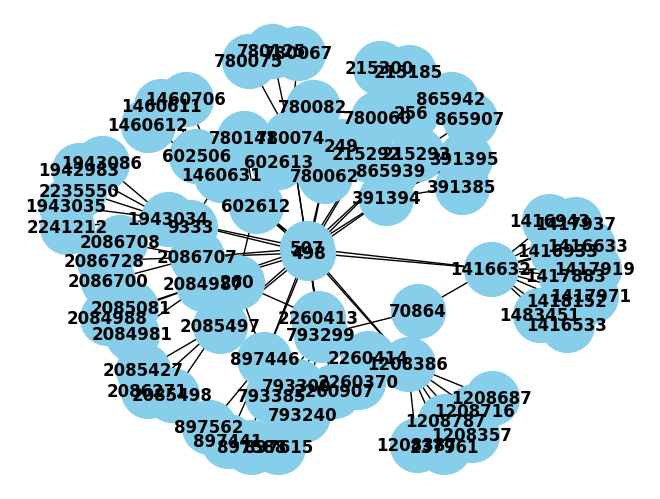

In [12]:
nx.draw(aggregated_graph, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.show()